<a href="https://colab.research.google.com/github/JonSax88/PracticalMachineLearning/blob/main/Module_5_Assignment_2_Bankrupty_Prediction_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 5 Assignment 2 - Company Bankruptcy Prediction (Kaggle)

Jonathan Sax <br>
Northwestern University <br>
Practical Machine Learning - MSDS 422 <br>
5/1/2022 <br>

## Requirements


- Conduct your analysis using a cross-validation design.
- Conduct / improve upon previous EDA.
- Build the following models at a minimum.
        Random Forest Classifier
        Gradient Boosted Trees
        Extra Trees
- Conduct hyperparameter tuning for the following at a minimum.
        n_estimators (number of trees)
        max_features (maximum features considered for splitting a node)
        max_depth (maximum number of levels in each tree)
        splitting criteria (entropy or gini)
- Compare your models using the F1-Score on a 20% validation set.


# Ingest

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingRegressor


%matplotlib inline
sns.set()

In [ ]:
data = pd.read_csv("data.csv")
data

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


# EDA

In [ ]:
missing = data.isnull().sum()
missing.sum()

0

In [ ]:
features = [f for f in data.columns if data.dtypes[f] != 'object']
features.remove('Bankrupt?')
features

[' ROA(C) before interest and depreciation before interest',
 ' ROA(A) before interest and % after tax',
 ' ROA(B) before interest and depreciation after tax',
 ' Operating Gross Margin',
 ' Realized Sales Gross Margin',
 ' Operating Profit Rate',
 ' Pre-tax net Interest Rate',
 ' After-tax net Interest Rate',
 ' Non-industry income and expenditure/revenue',
 ' Continuous interest rate (after tax)',
 ' Operating Expense Rate',
 ' Research and development expense rate',
 ' Cash flow rate',
 ' Interest-bearing debt interest rate',
 ' Tax rate (A)',
 ' Net Value Per Share (B)',
 ' Net Value Per Share (A)',
 ' Net Value Per Share (C)',
 ' Persistent EPS in the Last Four Seasons',
 ' Cash Flow Per Share',
 ' Revenue Per Share (Yuan ¥)',
 ' Operating Profit Per Share (Yuan ¥)',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Realized Sales Gross Profit Growth Rate',
 ' Operating Profit Growth Rate',
 ' After-tax Net Profit Growth Rate',
 ' Regular Net Profit Growth Rate',
 ' Continuous Net 

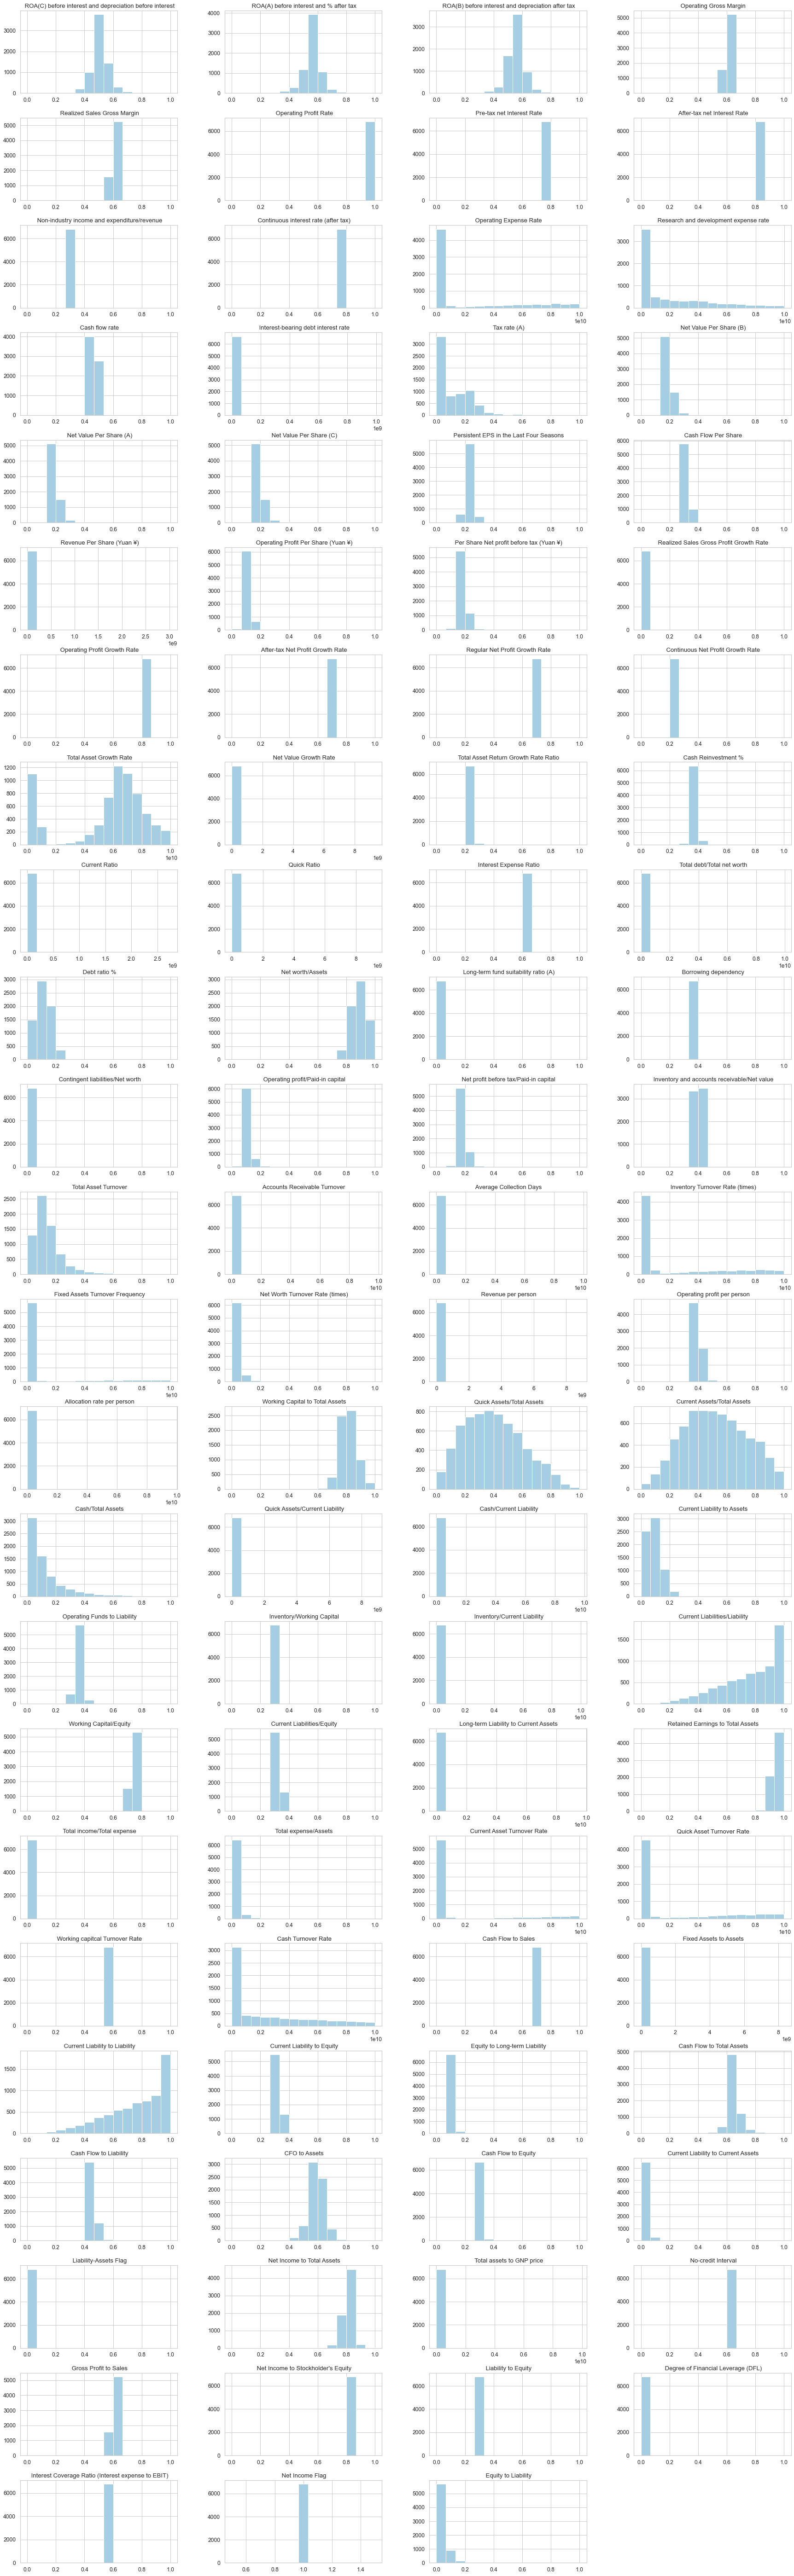

In [ ]:
sns.set(style='whitegrid', palette="Paired", font_scale=1.1, rc={"figure.figsize": [30, 102]})
data[features].hist(bins=15, layout=(24, 4));

<AxesSubplot:>

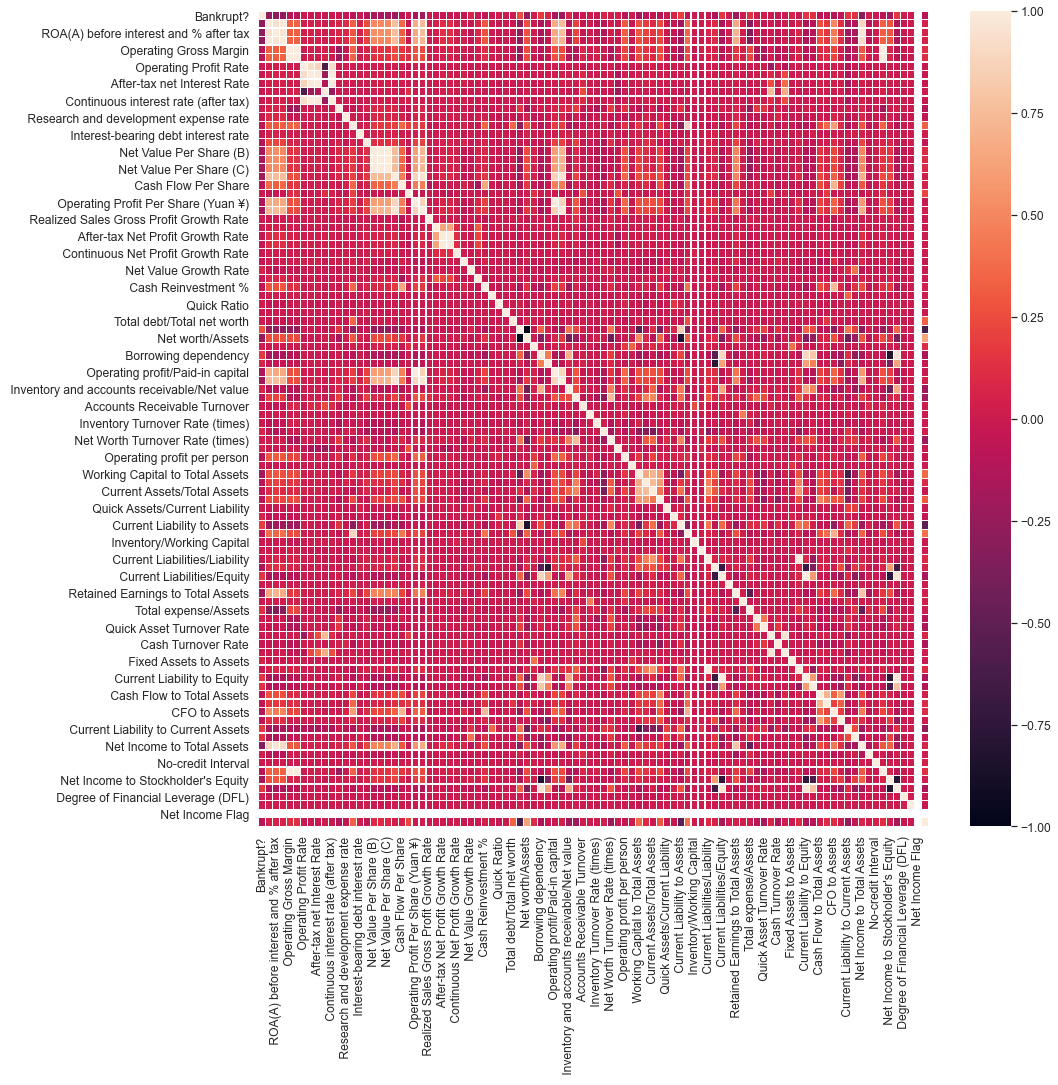

In [ ]:
correlation = data.corr()
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(correlation, ax = ax, linewidth = 0.1)

# Modeling

In [ ]:
X = data.drop('Bankrupt?', axis=1) # defines features (X's) as ALL the columns except 'Bankrupt?' column
y = data['Bankrupt?'] # defines response variable (y) as the 'Bankrupt?' column

Creating a 80% training set and 20% validation set.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Traversing through Chapter 7 source code notebook to become more familiar with Ensemble Learning (via the Bankrupty data).

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [ ]:
voting_clf.fit(X_train, y_train)

/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))



/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.9611436950146628
RandomForestClassifier 0.967741935483871
SVC 0.9626099706744868


/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier 0.9626099706744868


## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

A Random Forest is an improvement on bagged decision trees:

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [ ]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions


0.999266862170088

In [ ]:
from sklearn.metrics import roc_auc_score

# inspiration from kaggle.com/code/artemramus/bankrupt-random-forest-cost-sensitive

In [ ]:
print('Train Set')
pred = rnd_clf.predict_proba(X_train)
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))

Train Set
Random Forests roc-auc: 0.9682364043011908


In [ ]:
print('Test Set')
pred = rnd_clf.predict_proba(X_test)
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Test Set
Random Forests roc-auc: 0.9257799083075728


## Hyperparameter Tuning with GridSearchCV

In [ ]:
# set up a KFold cross-validation rule
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)

In [ ]:
%%time
# RandomForestClassifier: n_estimators, max_features, max_depth, criterion
rfc_grid = {'n_estimators': [200, 500],
            'max_leaf_nodes': [10, 16],
            'criterion': ['entropy', 'gini'],
            'max_features': ['log2', 'sqrt']}
rfc_cv = GridSearchCV(RandomForestClassifier(random_state=42),
            cv=kf, 
            param_grid=rfc_grid, 
            scoring='r2')
rfc_results = rfc_cv.fit(X, y)
print("RFC best score", rfc_results.best_score_)
print("RFC best params", rfc_results.best_params_)



RFC best score 0.04914604774713309
RFC best params {'criterion': 'gini', 'max_features': 'log2', 'max_leaf_nodes': 10, 'n_estimators': 500}
CPU times: user 9min 36s, sys: 2.73 s, total: 9min 39s
Wall time: 9min 44s


In [ ]:
%%time
rfc_n_estimators = rfc_results.best_params_['n_estimators']
rfc_max_leaf_nodes = rfc_results.best_params_['max_leaf_nodes']
rfc_criterion = rfc_results.best_params_['criterion']
rfc_max_features = rfc_results.best_params_['max_features']

score = cross_val_score(RandomForestClassifier(
            n_estimators=rfc_n_estimators, 
            max_leaf_nodes=rfc_max_leaf_nodes, 
            criterion=rfc_criterion, 
            max_features=rfc_max_features, 
            random_state=42),
            X, y, cv=kf)
print(f'Scores for each fold: {score}')
print("Accuracy: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))



Scores for each fold: [0.95894428 0.97214076 0.96041056 0.98533724 0.97360704 0.98093842
 0.97214076 0.96774194 0.95894428 0.969163  ]
Accuracy: 0.9699 (+/- 0.0170)
CPU times: user 32.6 s, sys: 160 ms, total: 32.8 s
Wall time: 32.9 s


In [ ]:
%%time
rfc_model = RandomForestClassifier(
            n_estimators=rfc_n_estimators, 
            max_leaf_nodes=rfc_max_leaf_nodes, 
            criterion=rfc_criterion, 
            max_features=rfc_max_features, 
            random_state=42)
rfc_model.fit(X, y)
y_pred = rfc_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print('confusion matrix:\n',cm)
print('accuracy score = ',accuracy_score(y_test, y_pred))
print("Classification Report:\n",classification_report(y_test, y_pred))

confusion matrix:
 [[1313    0]
 [  42    9]]
accuracy score =  0.969208211143695
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1313
           1       1.00      0.18      0.30        51

    accuracy                           0.97      1364
   macro avg       0.98      0.59      0.64      1364
weighted avg       0.97      0.97      0.96      1364

CPU times: user 3.65 s, sys: 17.4 ms, total: 3.66 s
Wall time: 3.67 s


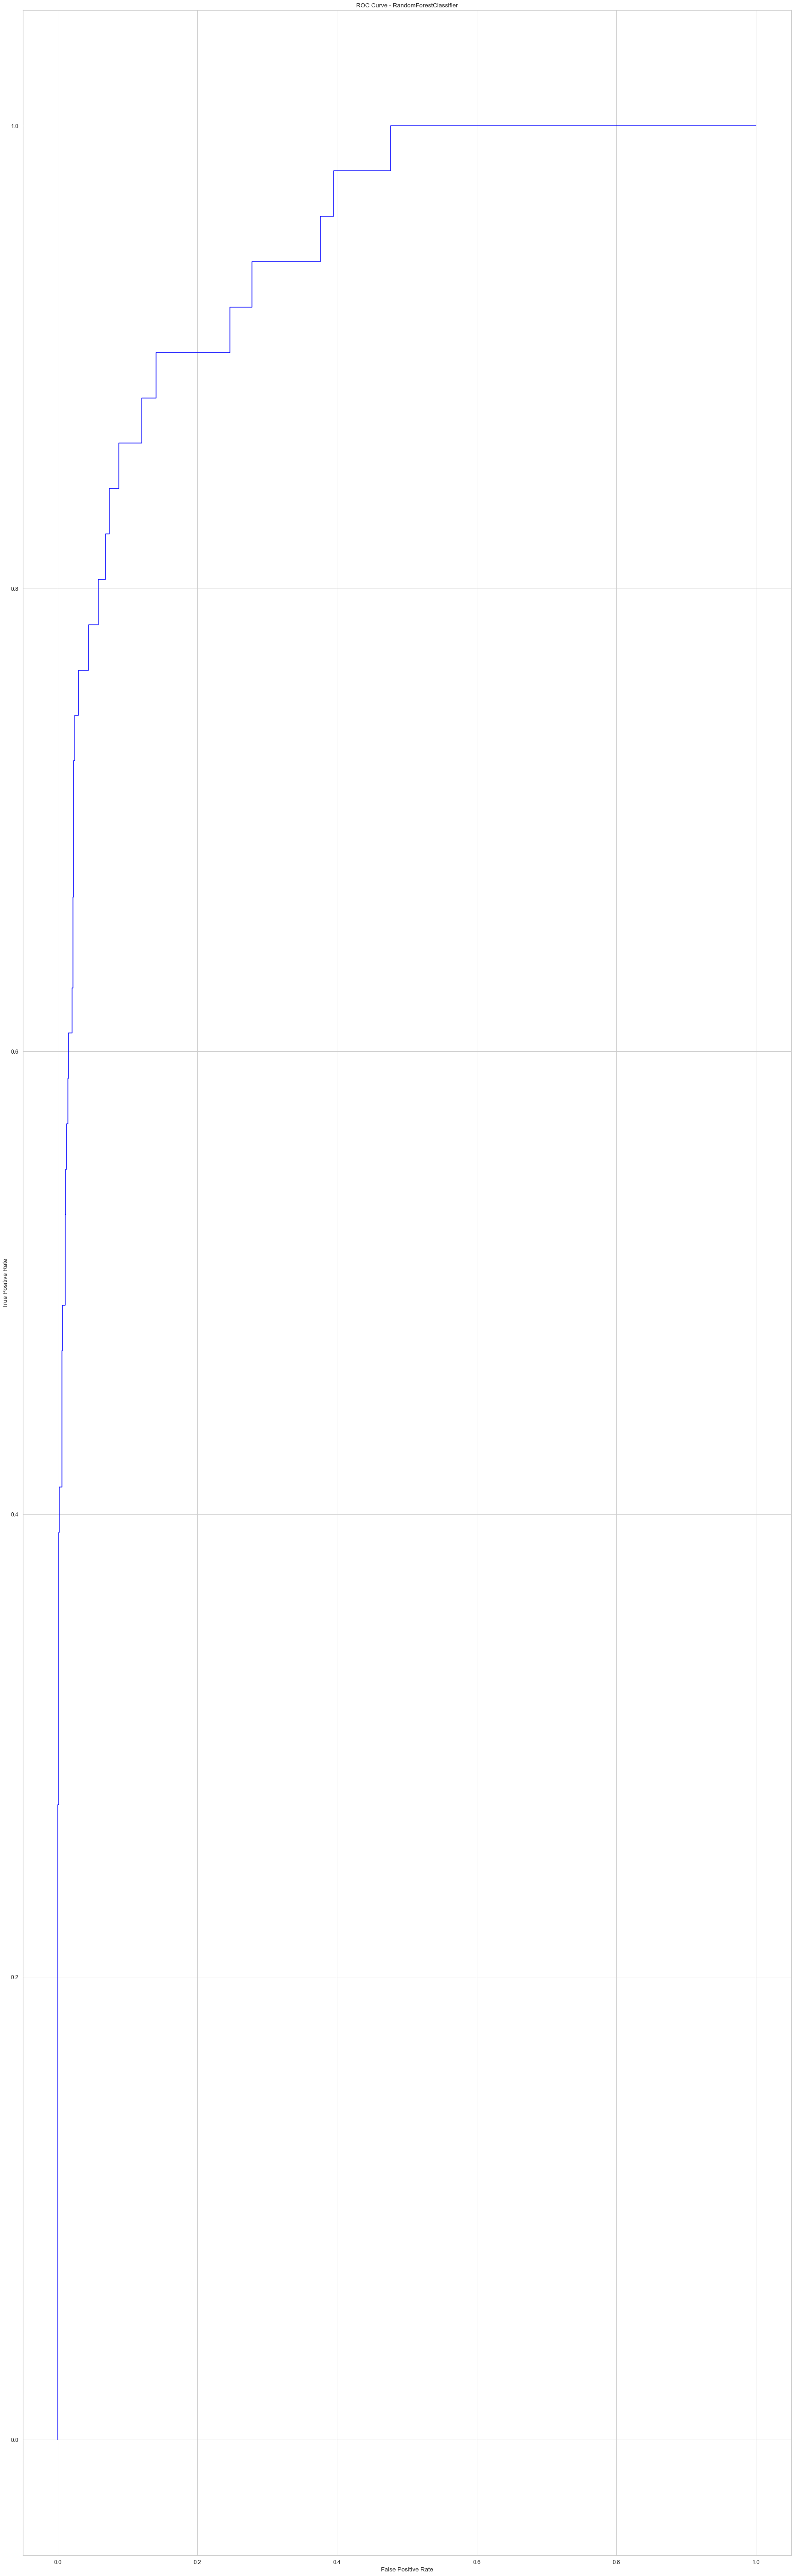

In [ ]:
#define metrics
y_pred_proba = rfc_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr, color="blue")
plt.title('ROC Curve - RandomForestClassifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



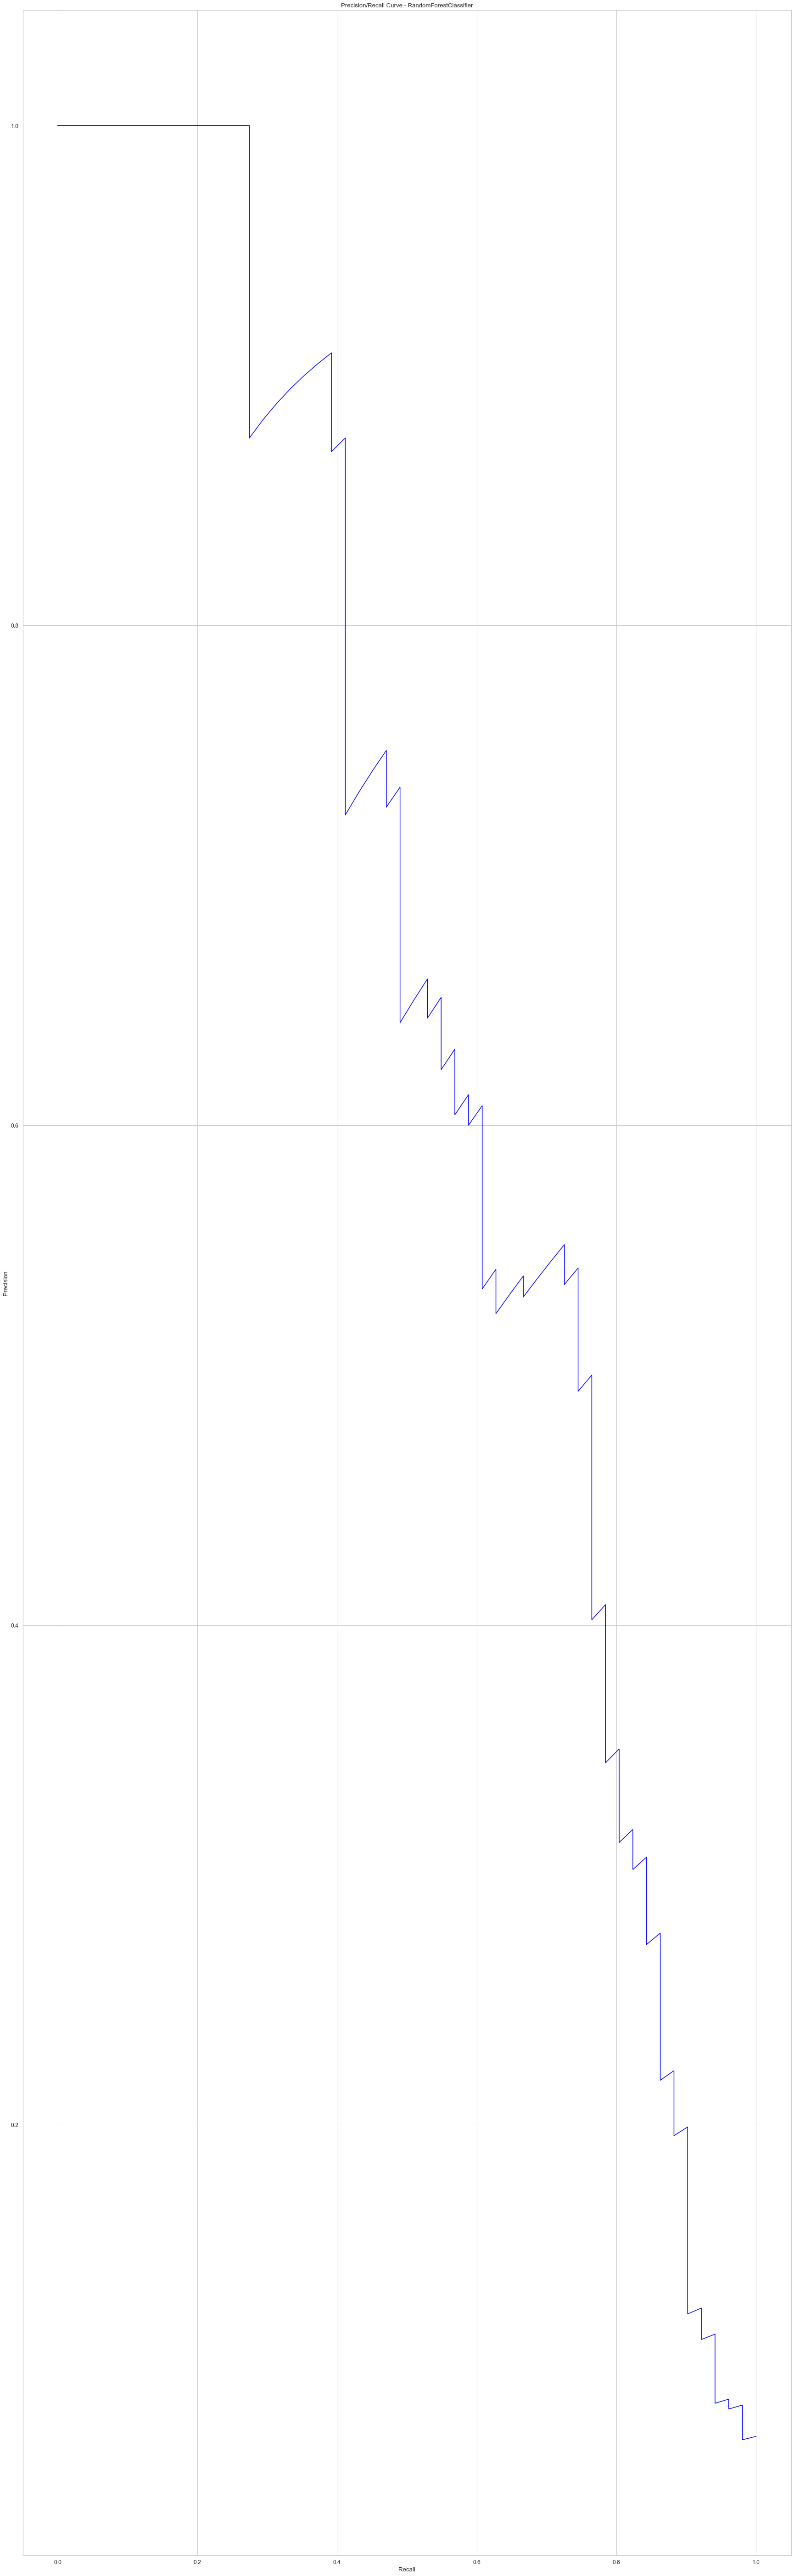

In [ ]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision/Recall Curve - RandomForestClassifier')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()



In [ ]:
feature_imp = pd.Series(rfc_model.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp.head(10)

 Net Value Growth Rate                       0.057218
 Persistent EPS in the Last Four Seasons     0.048877
 Net profit before tax/Paid-in capital       0.041920
 Net Income to Stockholder's Equity          0.040981
 Borrowing dependency                        0.036279
 Net Value Per Share (A)                     0.031321
 Per Share Net profit before tax (Yuan ¥)    0.030759
 Net Value Per Share (C)                     0.028940
 Net Value Per Share (B)                     0.028501
 Net Income to Total Assets                  0.025799
dtype: float64

In [ ]:
# Removing highly correlated features

cor_matrix = data[features].corr().abs()

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.15)]
print(); 
print(to_drop)

lessfeatures=[x for x in features if x not in to_drop]


dfless = data.drop(to_drop, axis=1)



dfless.info()




[' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Operating Expense Rate', ' Cash flow rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' After-tax Net Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Total Asset Return Growth Rate Ratio', ' Cash Reinvestment %', ' Total debt/Total net worth', ' Debt ratio %', ' Net worth/Assets', ' Borrowing dependency', ' Contingent liabilities/Net worth', ' Operating profit/Paid-in capital', ' Net profit before tax/Paid-in capital', ' Inventory a

<ipython-input-100-1841f3ad9dfb>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


In [ ]:
X2 = dfless.drop('Bankrupt?', axis=1) # defines features (X's) as ALL the columns except 'Bankrupt?' column
y2 = dfless['Bankrupt?'] # defines response variable (y) as the 'Bankrupt?' column

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# I will use X2 and y2 in the gradient boost trees model a little later

### Plotting a tree

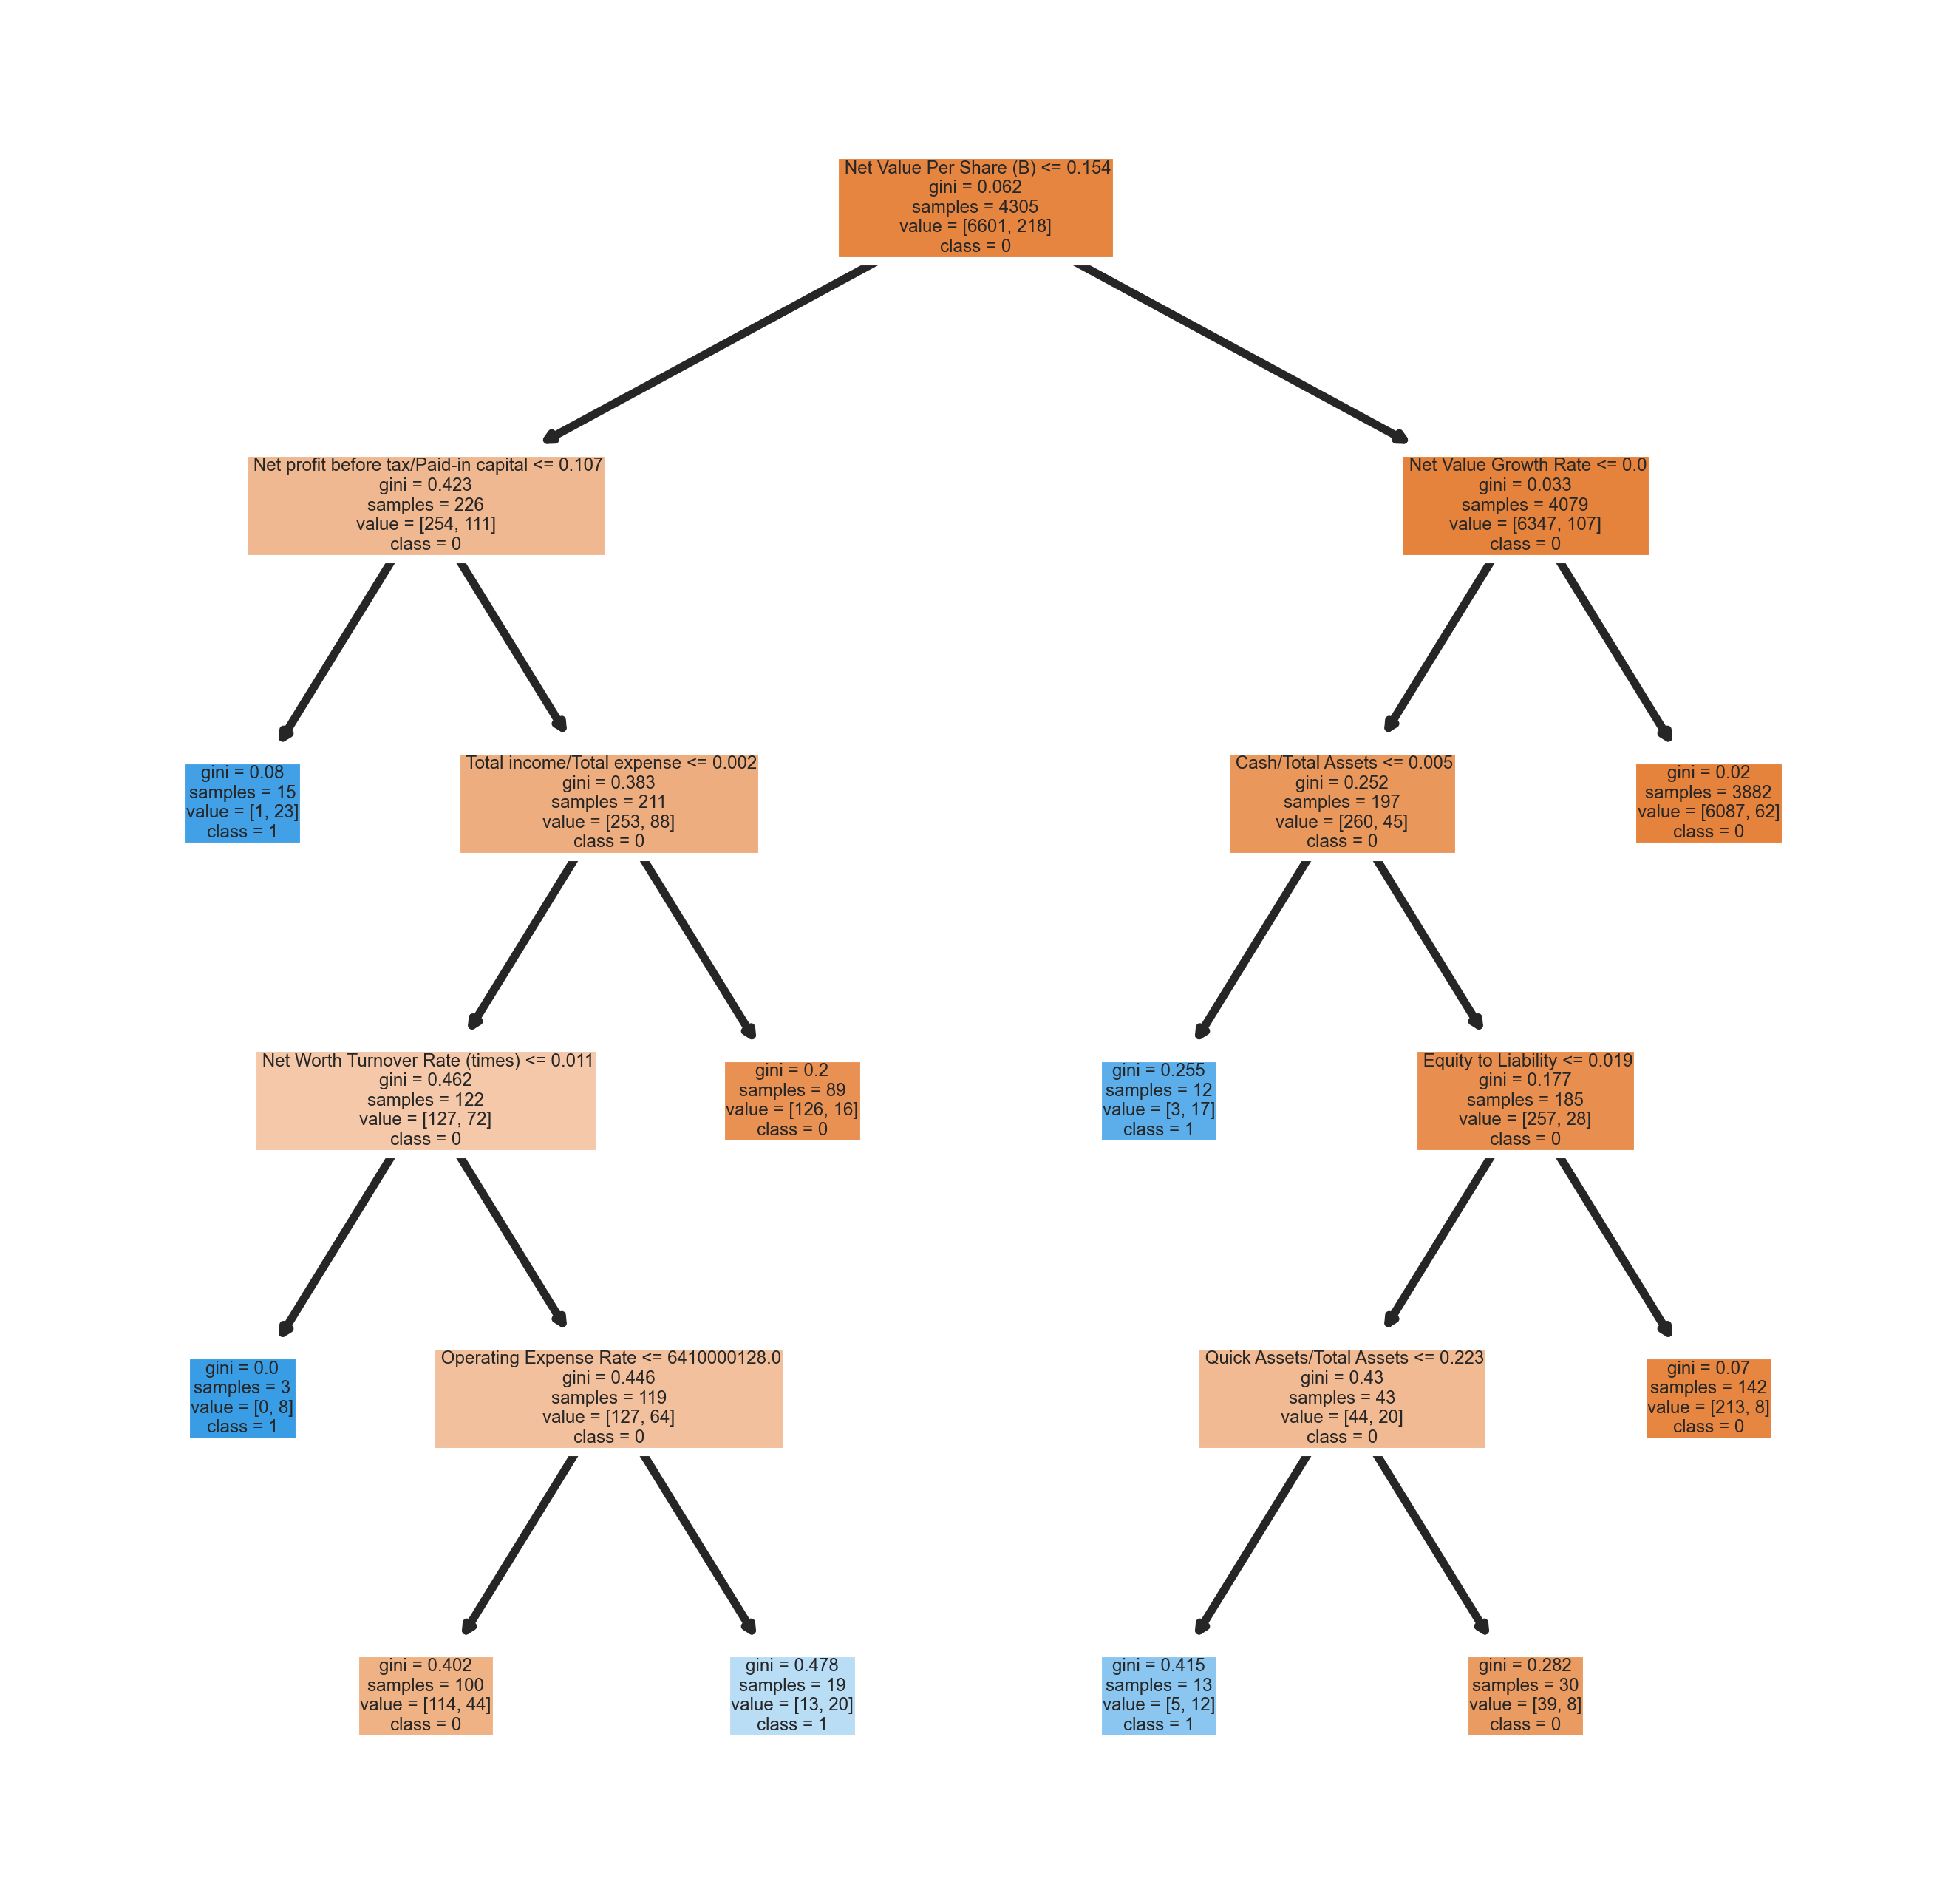

In [ ]:

# To visualize individual decision trees
from sklearn import tree
from sklearn.tree import export_text


fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rfc_model.estimators_[0],
               feature_names = features, 
               class_names=['0','1'],
               filled = True);

# Extra Trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std

In [ ]:
#https://machinelearningmastery.com/extra-trees-ensemble-with-python/

# define the model
model = ExtraTreesClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.970 (0.003)


In [ ]:
model.fit(X, y)

ExtraTreesClassifier()

### Extra Trees with Hyperparameter Tuning

In [ ]:
%%time

# ExtraTreesClassifier hypertuning: n_estimators, max_depth, criterion, max_features
xtc_grid = {'n_estimators': [150, 200],
            'max_depth': [15,20],
            'criterion': ['entropy', 'gini'],
            'max_features': ['sqrt','log2']}
xtc_cv = GridSearchCV(ExtraTreesClassifier(random_state=42), 
            cv=kf, 
            param_grid=xtc_grid, 
            scoring='r2')
xtc_results = xtc_cv.fit(X, y)
print("XTC best score", xtc_results.best_score_)
print("XTC best params", xtc_results.best_params_)



XTC best score 0.047053227186943145
XTC best params {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}
CPU times: user 1min 44s, sys: 1.66 s, total: 1min 46s
Wall time: 1min 46s


In [ ]:
%%time
xtc_n_estimators = xtc_results.best_params_['n_estimators']
xtc_max_depth = xtc_results.best_params_['max_depth']
xtc_criterion = xtc_results.best_params_['criterion']
xtc_max_features = xtc_results.best_params_['max_features']

score = cross_val_score(ExtraTreesClassifier(
            n_estimators=xtc_n_estimators, 
            max_depth=xtc_max_depth, 
            criterion=xtc_criterion, 
            max_features=xtc_max_features, 
            random_state=42),
            X, y, cv=kf)
print(f'Scores for each fold: {score}')
print("Accuracy: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))

Scores for each fold: [0.96041056 0.97360704 0.96187683 0.98240469 0.97653959 0.98093842
 0.97214076 0.96480938 0.96041056 0.96769457]
Accuracy: 0.9701 (+/- 0.0157)
CPU times: user 7.02 s, sys: 127 ms, total: 7.15 s
Wall time: 7.18 s


In [ ]:
%%time
xtc_model = ExtraTreesClassifier(
            n_estimators=xtc_n_estimators, 
            max_depth=xtc_max_depth, 
            criterion=xtc_criterion,
            max_features=xtc_max_features,
            random_state=42)
xtc_model.fit(X, y)
y_pred = xtc_model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print('confusion matrix:\n',cm)
print('accuracy score = ',accuracy_score(y_test,y_pred))
print("Classification Report:\n",classification_report(y_test,y_pred))


confusion matrix:
 [[1313    0]
 [   1   50]]
accuracy score =  0.999266862170088
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1313
           1       1.00      0.98      0.99        51

    accuracy                           1.00      1364
   macro avg       1.00      0.99      0.99      1364
weighted avg       1.00      1.00      1.00      1364

CPU times: user 780 ms, sys: 13.8 ms, total: 794 ms
Wall time: 794 ms


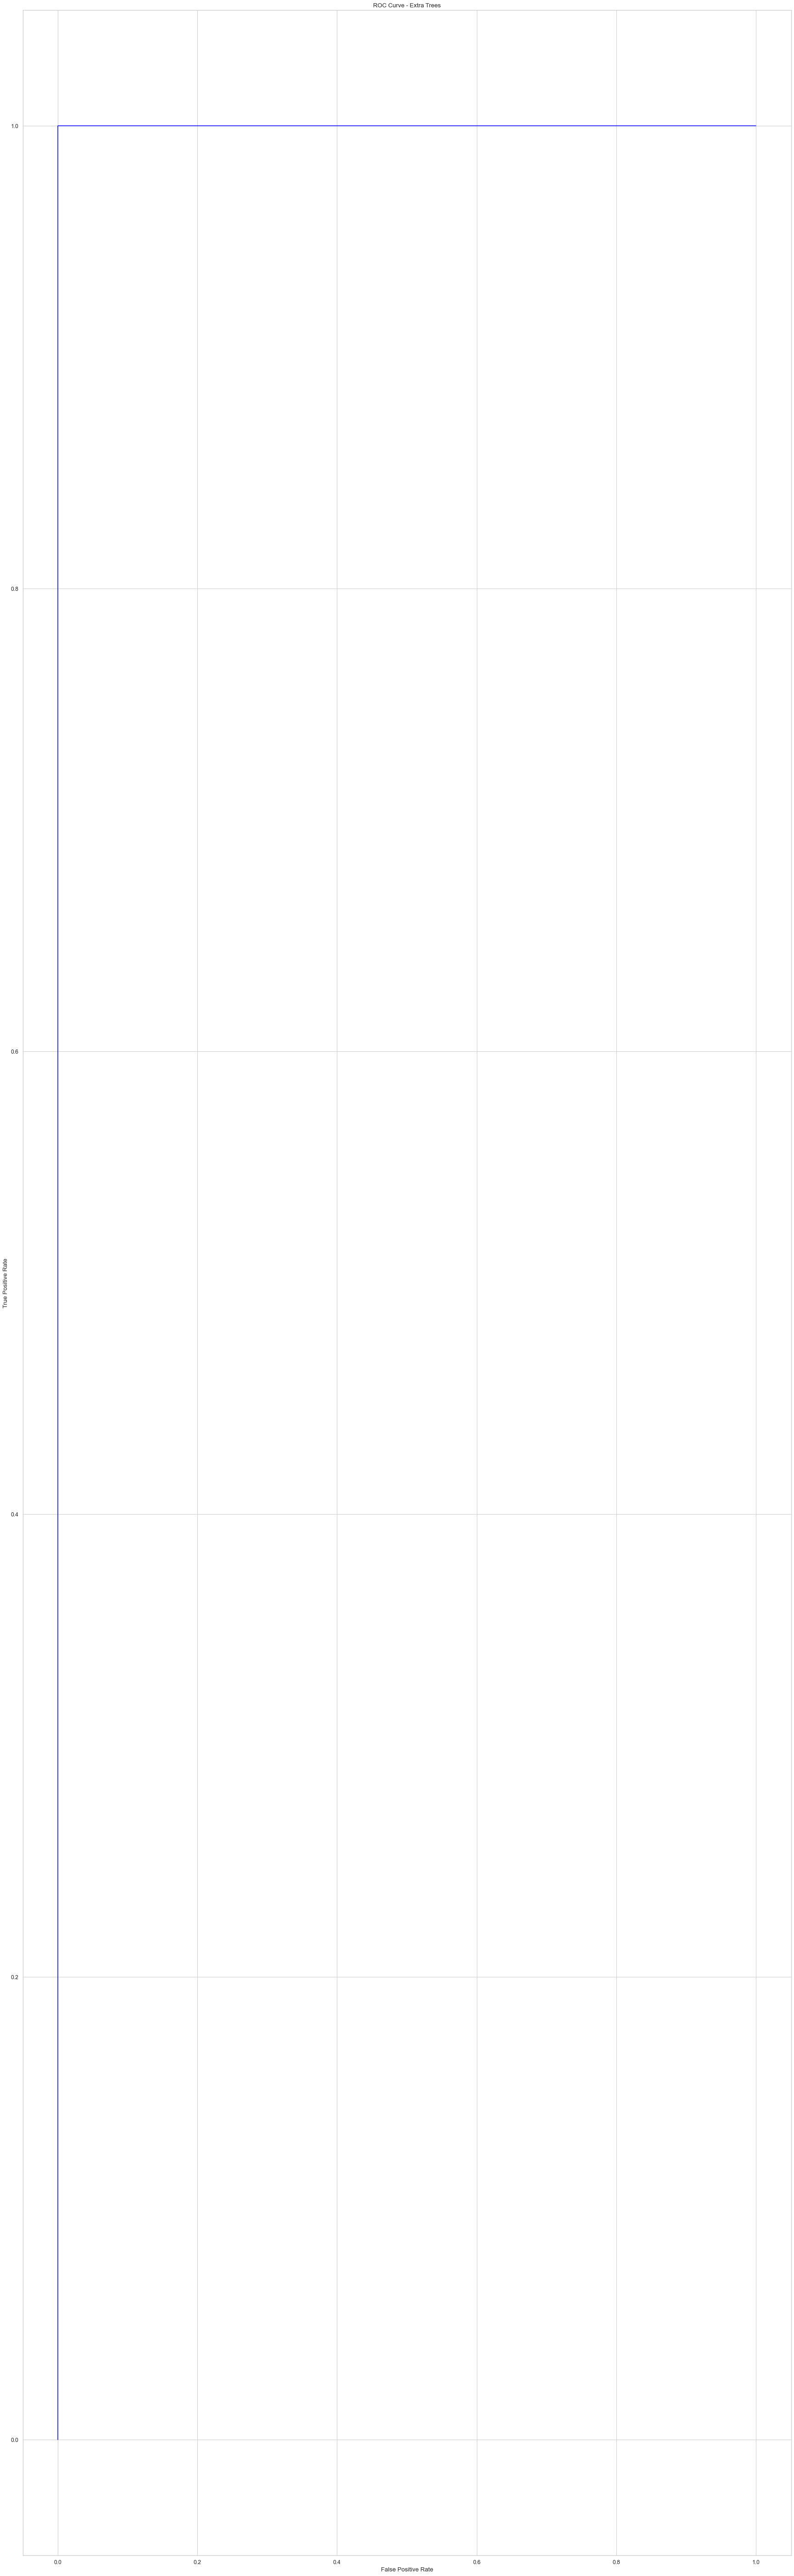

In [ ]:
#Extra Trees ROC curve -- define metrics
y_pred_proba = xtc_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr, color="blue")
plt.title('ROC Curve - Extra Trees')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


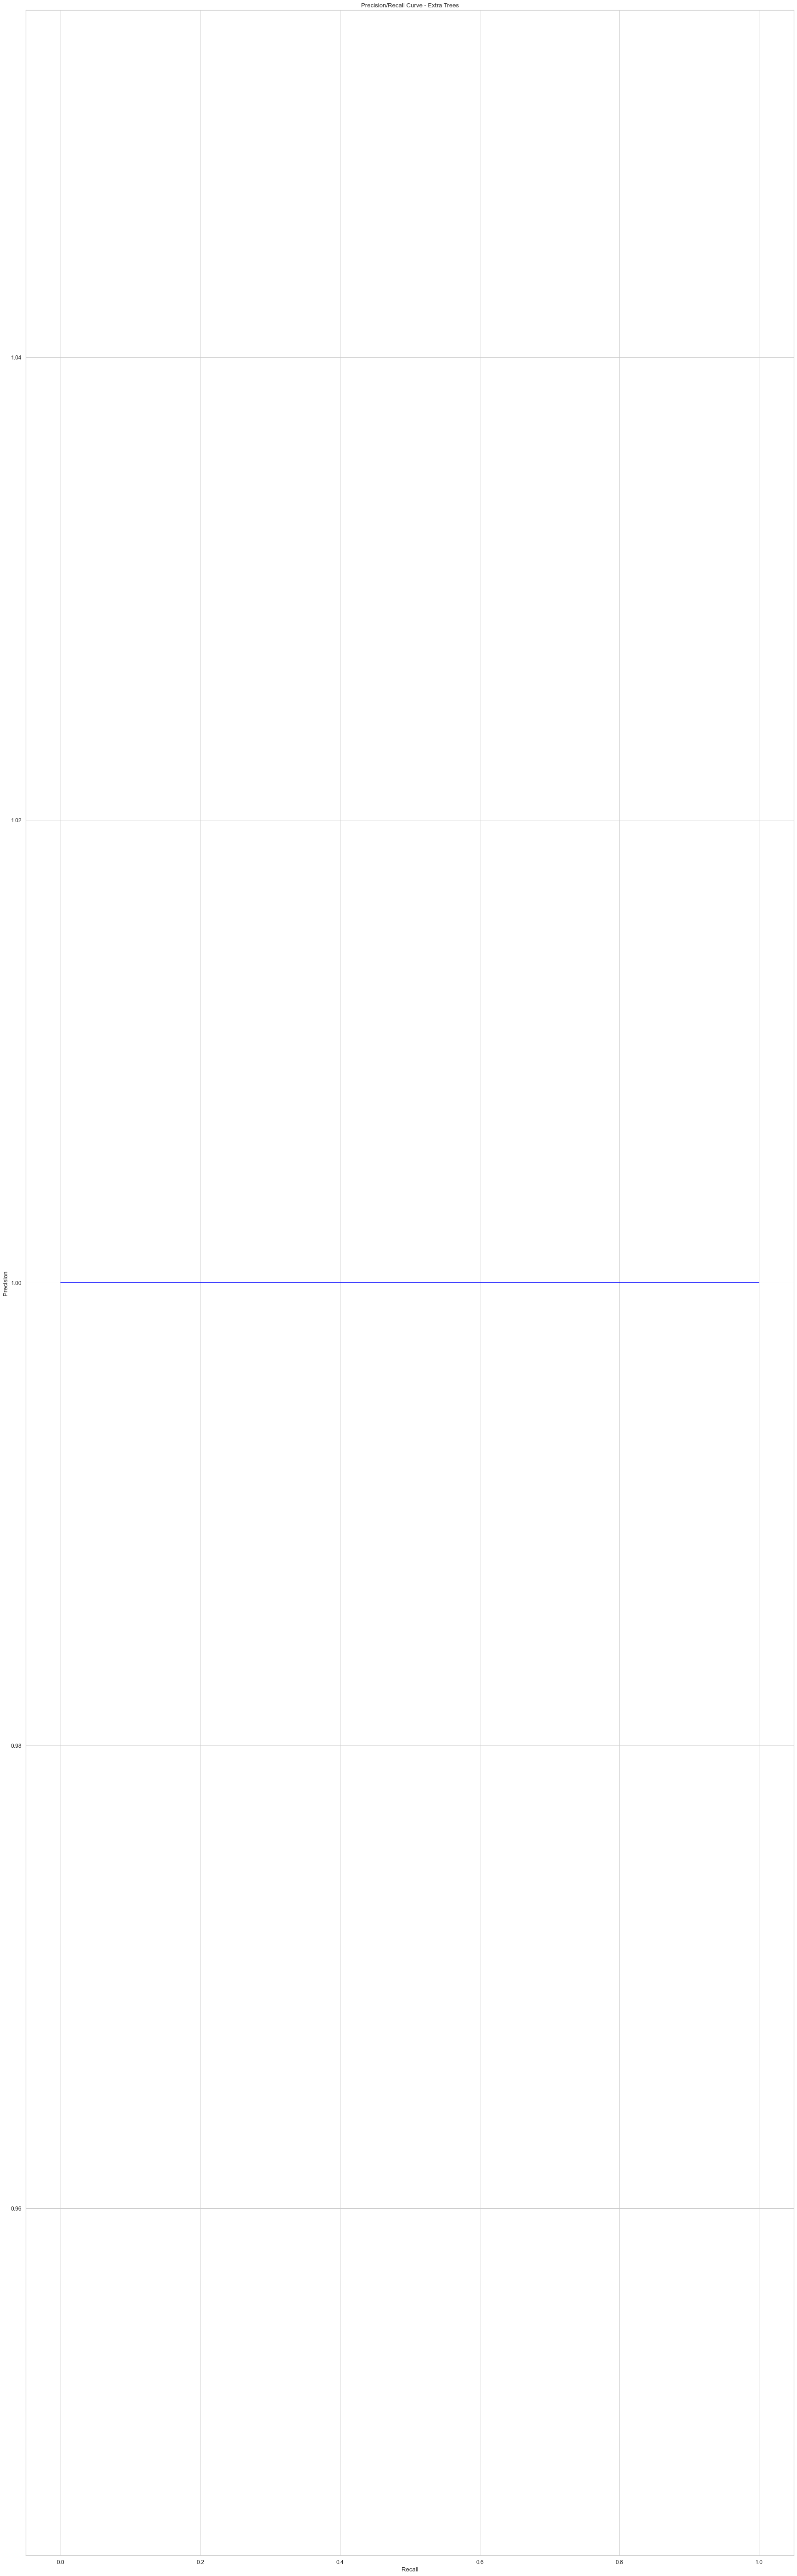

In [ ]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision/Recall Curve - Extra Trees')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

# Gradient Boosted Trees

In [ ]:
%%time
# GradientBoostingClassifier hypertuning: n_estimators, max_depth, learning_rate
gbc_grid = {'n_estimators': [200],
            'max_depth': [10],
            'learning_rate': [0.5],
            'criterion': ['squared_error','mse'],
            'max_features': ['log2', 'sqrt']}
gbc_cv = GridSearchCV(GradientBoostingClassifier(random_state=42), 
            param_grid=gbc_grid, 
            cv=kf, 
            scoring='r2')
gbc_results = gbc_cv.fit(X2,y2)
print("GBR best score", gbc_results.best_score_)
print("GBR best params", gbc_results.best_params_)


/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/s

/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.01507813 0.01507813]
  warnings.warn(


GBR best score 0.015078131740219214
GBR best params {'criterion': 'mse', 'learning_rate': 0.5, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}
CPU times: user 1min 18s, sys: 196 ms, total: 1min 18s
Wall time: 1min 19s


In [ ]:


%%time
gbc_n_estimators = gbc_results.best_params_['n_estimators']
gbc_max_depth = gbc_results.best_params_['max_depth']
gbc_learning_rate = gbc_results.best_params_['learning_rate']

score = cross_val_score(GradientBoostingClassifier(
            n_estimators=gbc_n_estimators, 
            max_depth=gbc_max_depth, 
            learning_rate=gbc_learning_rate, 
            max_features='log2', 
            random_state=42),
            X, y, cv=kf)
print(f'Scores for each fold: {score}')
print("Accuracy: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))



Scores for each fold: [0.95747801 0.97214076 0.96187683 0.98240469 0.97507331 0.97947214
 0.97067449 0.96334311 0.96187683 0.969163  ]
Accuracy: 0.9694 (+/- 0.0155)
CPU times: user 55.1 s, sys: 169 ms, total: 55.3 s
Wall time: 55.5 s


In [ ]:
# hypertune n_estimators via early stopping
gbc_model = GradientBoostingClassifier(
            n_estimators=gbc_n_estimators, 
            max_depth=gbc_max_depth, 
            learning_rate=gbc_learning_rate, 
            max_features='log2', 
            random_state=42)
gbc_model.fit(X, y)
y_pred = gbc_model.predict(X_test)



In [ ]:


errors = [mean_squared_error(y_test, y_pred)
          for y_pred in gbc_model.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors) + 1
bst_n_estimators



6

In [ ]:


%%time
gbc_best = GradientBoostingClassifier(
            n_estimators=bst_n_estimators, 
            max_depth=gbc_max_depth, 
            learning_rate=gbc_learning_rate, 
            max_features='log2', 
            random_state=42)
gbc_best.fit(X, y)

y_pred = gbc_best.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print('confusion matrix:\n',cm)
print('accuracy score = ',accuracy_score(y_test,y_pred))
print("Classification Report:\n",classification_report(y_test,y_pred))



confusion matrix:
 [[1313    0]
 [   0   51]]
accuracy score =  1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1313
           1       1.00      1.00      1.00        51

    accuracy                           1.00      1364
   macro avg       1.00      1.00      1.00      1364
weighted avg       1.00      1.00      1.00      1364

CPU times: user 195 ms, sys: 5.1 ms, total: 200 ms
Wall time: 202 ms


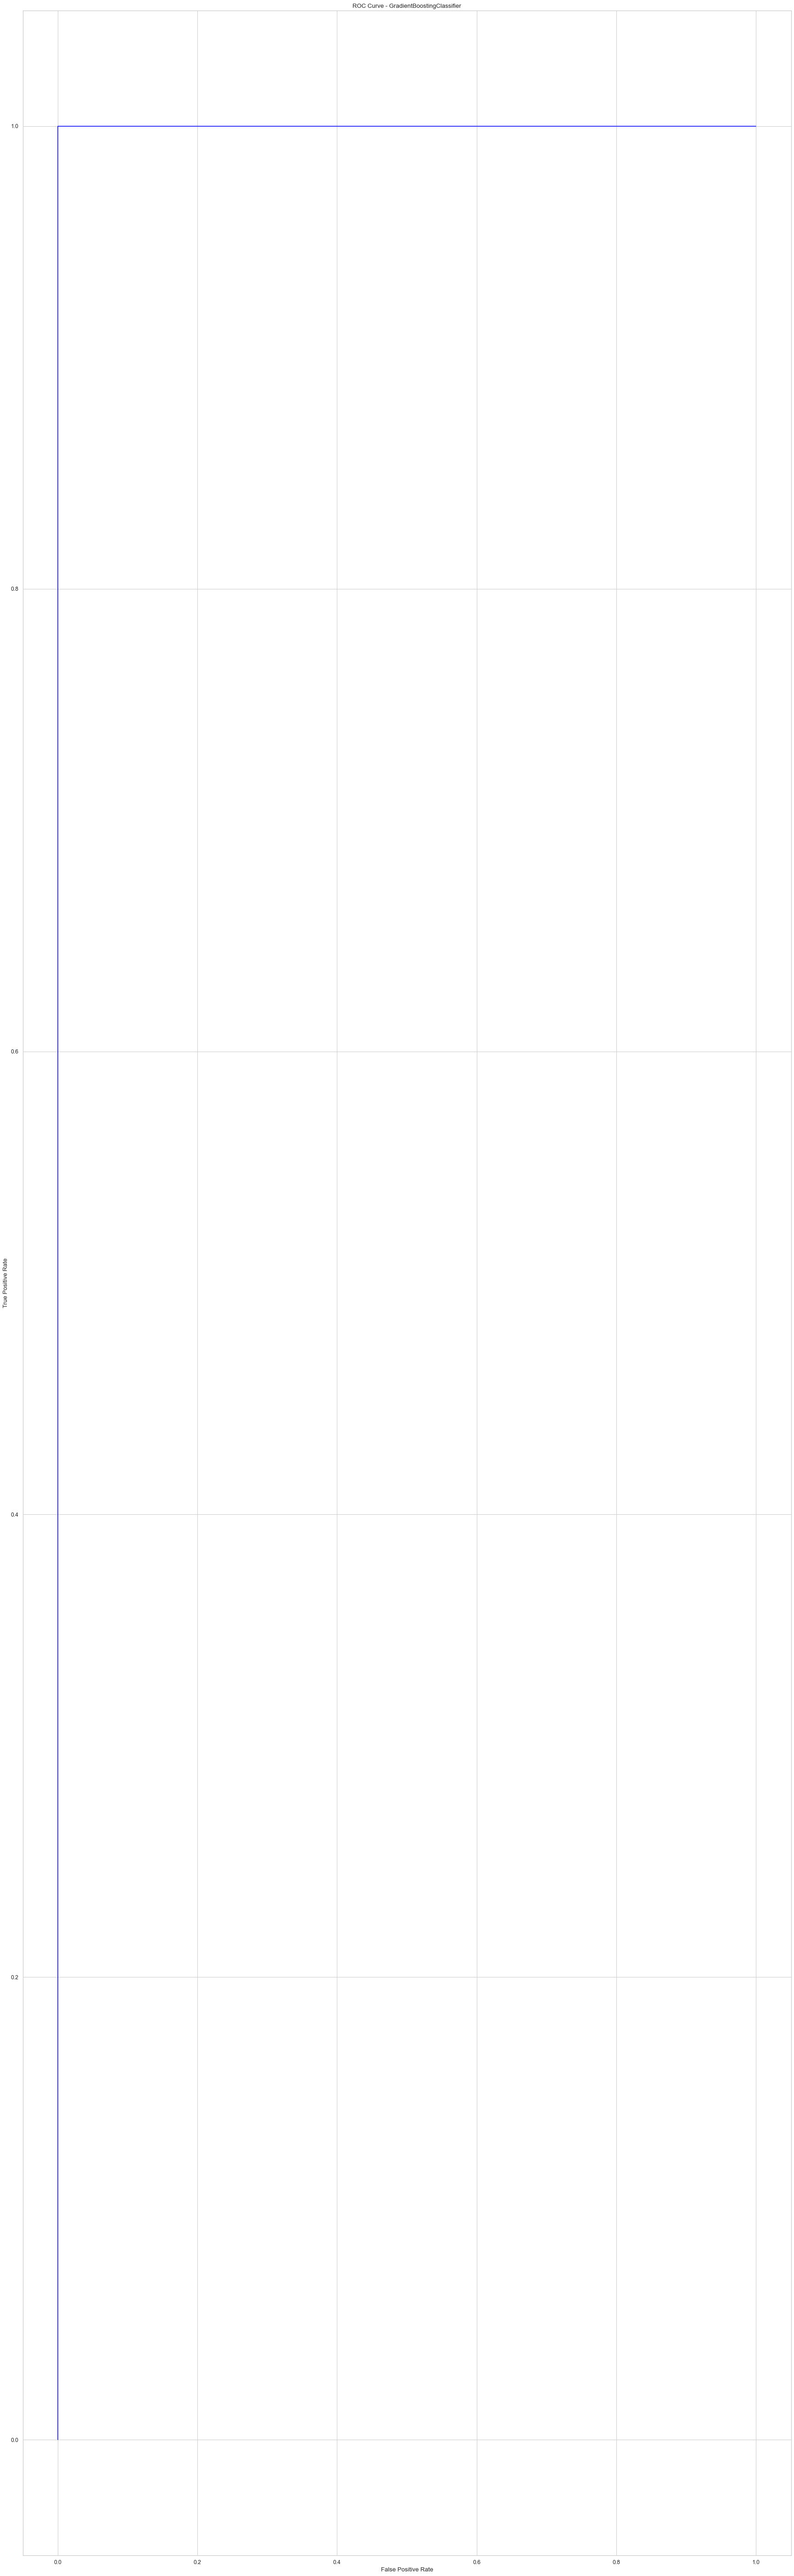

In [ ]:


#define metrics
y_pred_proba = gbc_best.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr, color="blue")
plt.title('ROC Curve - GradientBoostingClassifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



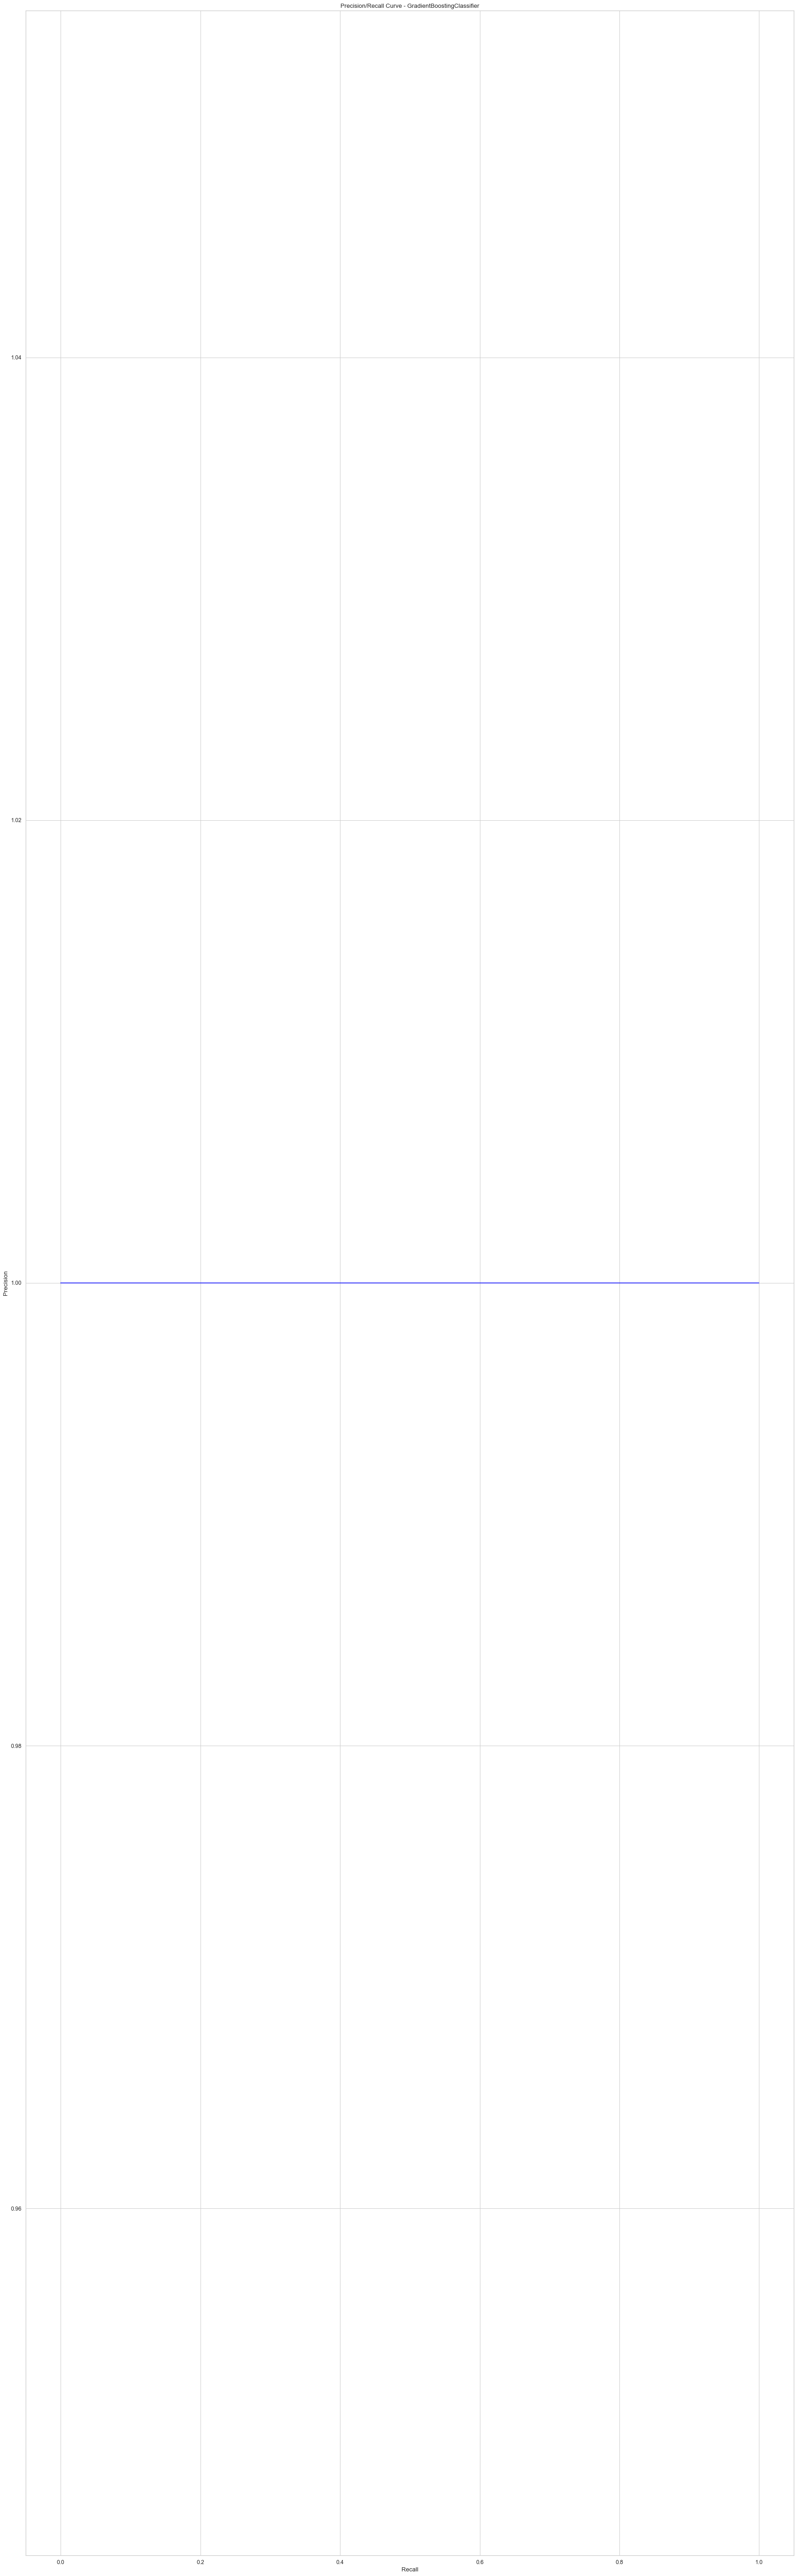

In [ ]:


#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision/Recall Curve - GradientBoostingClassifier')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()



# Conclusion

My gradient boosting classifier took the longest to run (by far) and I had to greatly limit my features in order to get the model to run after hyperparameter tuning. The results were not very helpful/indicative. My Extra Trees classifier had the highest F1-score, but it appears almost too good to be true with 0.99. Meanwhile, my Random Forests classifier performed more realistically, but had a lot of false negatives. Further hyperparameter tuning will be necessary with that model.